In [27]:
"""
Sources:
https://github.com/heaversm/runway-stylegan-animations
https://archive.ph/uL8nI (https://heartbeat.comet.ml/animated-stylegan-image-transitions-with-runwayml-57a2e20db80f)
"""

import os
import math
import json
import uuid
from urllib.request import urlopen
from typing import List

import requests
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from opensimplex import OpenSimplex
from dotenv import load_dotenv

from art_generation.math_utils import random_noise_sample

load_dotenv()
%matplotlib inline


In [28]:
def generate_image(
    img_size: int,
    cxs: List[int],
    cys: List[int],
    angle: float,
    diameter: int,
    tmp: OpenSimplex,
    minimum: int = -1,
    maximum: int = 1,
):
    """Generate some random noise using the arguments provided that will be used in the call to
    Runway ML landscape API.
    """
    random_vector = random_noise_sample(
        img_size, cxs, cys, angle, diameter, tmp, minimum, maximum
    )
    inputs = {"z": random_vector, "truncation": 0.5}

    url = os.environ["RUNWAY_URL"]
    bearer_token = os.getenv("BEARER_TOKEN", None)
    if bearer_token:
        auth = {"Authorization": f"Bearer {bearer_token}"}
    else:
        auth = {}

    headers = {"Accept": "application/json", "Content-Type": "application/json", **auth}
    data = json.dumps(inputs).encode("utf8")
    resp = requests.post(url, headers=headers, data=data)

    if resp.status_code == 200:
        resp_json = resp.json()
        image = resp_json["image"]
        with urlopen(image) as response:
            data = response.read()
        nparr = np.frombuffer(data, np.uint8)
        return cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR)
    else:
        raise RuntimeError(f"HTTP ERROR: {resp.reason}")


In [29]:
def create_video(random_id: str, images: list, fps: int = 5):
    """Creates a GIF from the images retrieved from Runway ML.
    """
    ims = []
    fig = plt.figure()
    for image in images:
        im = plt.imshow(image, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    print("Creating Video...")
    dir_name = "./gif_output"
    try:
        os.makedirs(dir_name)
    except FileExistsError:
        pass
    file_path = os.path.join(dir_name, f"dynamic_images_{random_id}.gif")
    writergif = animation.PillowWriter(fps=fps)
    ani.save(file_path, writer=writergif)
    print(f"Video saved to: {file_path}")
    # plt.show()  # This doesnt work


In [30]:
def space_walk(random_id: str, num_frames: int = 100, save_output: bool = False):
    """Perform a latent space walk along the images that are being generated from the StyleGAN Landscape model.

    Depending on the number of frames we chose, we will generate that number of images from StyleGAN.
    Each iteration we increment the `angle` variable using the equation: 2 * pi / (24 * 60).
    This incrementing of the angle is what will allow us to smoothly transition between images.
    """
    img_size = 512
    angle = 0
    diameter = 20
    tmp = OpenSimplex()
    minimum = -1
    maximum = 1
    two_pi = math.pi * 2.0
    cxs = [np.random.randint(1000) for _ in range(img_size)]
    cys = [np.random.randint(1000) for _ in range(img_size)]
    images = []
    dir_path = os.path.join("./images_output", random_id)

    for i in range(num_frames):
        image = generate_image(
            img_size, cxs, cys, angle, diameter, tmp, minimum, maximum
        )

        images.append(image)

        # Incrementing this angle is what is smoothly transitioning between the images.
        da = two_pi / (24 * 60)
        angle += da

        if save_output:
            try:
                os.makedirs(dir_path)
            except FileExistsError:
                pass
            # plt.imshow(image)
            # plt.show()
            file_path = os.path.join(dir_path, f"{i}.jpg")
            cv2.imwrite(file_path, image)
    print(f"Saved images to {dir_path}")

    return images


In [31]:
random_id = str(uuid.uuid4())[:8]

In [32]:
images = space_walk(random_id, num_frames = 40, save_output = True)

Saved images to ./images_output/03eee161


Creating Video...
Video saved to: ./gif_output/dynamic_images_03eee161.gif


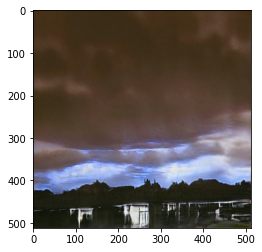

In [33]:
create_video(random_id, images, fps=5)